In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create the engine using the hawaii.sqlite file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# view the data types in the Measurement table
inspector = inspect(engine)
meas_data = inspector.get_columns('measurement')
[(c['name'], c['type'],c['primary_key']) for c in meas_data]

[('id', INTEGER(), 1),
 ('station', TEXT(), 0),
 ('date', TEXT(), 0),
 ('prcp', FLOAT(), 0),
 ('tobs', FLOAT(), 0)]

In [11]:
# view the data in the Measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
# view the data types in the Station table
inspector = inspect(engine)
sta_data = inspector.get_columns('station')
[(c['name'], c['type'],c['primary_key']) for c in sta_data]

[('id', INTEGER(), 1),
 ('station', TEXT(), 0),
 ('name', TEXT(), 0),
 ('latitude', FLOAT(), 0),
 ('longitude', FLOAT(), 0),
 ('elevation', FLOAT(), 0)]

In [13]:
# view the data in the Station table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

Text(0.5, 0, 'Date')

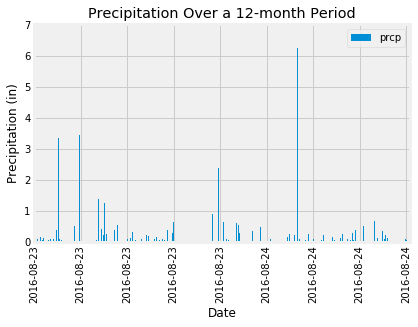

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# identify what the most recent date is in the data set
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# last_date 

# use the date found in the query above to identify the date a year prior 
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation data
precip_query = session.query(Measurement.date, Measurement.prcp).filter(func.strftime(Measurement.date)>=year_ago)

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.read_sql_query(precip_query.statement, precip_query.session.bind).set_index('date')

# Sort the dataframe by date and remove null values
date_sort_df = measurement_df.sort_values(by=['date'])
date_sort_df = date_sort_df.dropna(how='any')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = date_sort_df.plot(kind="bar", title="Precipitation Over a 12-month Period")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.ylabel("Precipitation (in)")
plt.xlabel("Date")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sum_stats = date_sort_df.describe()
sum_stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(Station.station).group_by(Station.station).distinct().count()
print(f"The total number of stations is {station_num}.")

The total number of stations is 9.


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count()).group_by(Measurement.station).all()
stations = []

for record in station_count:
    (station, count) = record
    stations.append(record)

stations.sort(reverse = True)

print(stations)
print('-'*30)
print(f"Station {stations[0][0]} has the highest number of observations, {stations[0][1]} observations.")

[('USC00519523', 2669), ('USC00519397', 2724), ('USC00519281', 2772), ('USC00518838', 511), ('USC00517948', 1372), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00513117', 2709), ('USC00511918', 1979)]
------------------------------
Station USC00519523 has the highest number of observations, 2669 observations.


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_min = round(session.query(func.min(Measurement.tobs)).filter(Measurement.station == stations[0][0]).scalar(),1)
station_max = round(session.query(func.max(Measurement.tobs)).filter(Measurement.station == stations[0][0]).scalar(),1)
station_avg = round(session.query(func.avg(Measurement.tobs)).filter(Measurement.station == stations[0][0]).scalar(),1)
print(f'The lowest temperature at station {stations[0][0]} is {station_min} degrees.')
print(f'The highest temperature at station {stations[0][0]} is {station_max} degrees.')
print(f'The average temperature at station {stations[0][0]} is {station_avg} degrees.')

The lowest temperature at station USC00519523 is 56.0 degrees.
The highest temperature at station USC00519523 is 85.0 degrees.
The average temperature at station USC00519523 is 74.5 degrees.


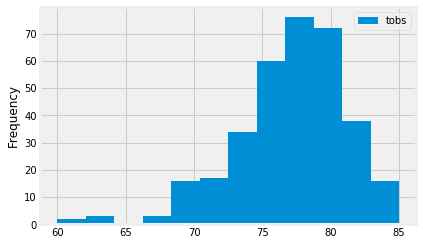

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# confirm the most recent date for this particular station is the same as the most recent date for all stations: 2017-08-23
last_date = session.query(Measurement.date).filter(Measurement.station == stations[0][0]).\
   order_by(Measurement.date.desc()).first()
# last_date

# Perform a query to retrieve the date and precipitation scores
temp_query = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == stations[0][0]).\
   filter(func.strftime(Measurement.date)>=year_ago)

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_df = pd.read_sql_query(temp_query.statement, temp_query.session.bind).set_index('date')

# Sort the dataframe by date and remove null values
sorted_df = temp_df.sort_values(by=['date'])
sorted_df = sorted_df.dropna(how='any')

# plot histogram
temp_plot = sorted_df.plot.hist(bins=12)


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
